<a href="https://colab.research.google.com/github/jjhurtadoa/Modelos-/blob/main/Ravdess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leer archivos desde Kaggle

In [ ]:
!pip install -U kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juanjosehurtado","key":"b22c794e7579fcf4388a8ab3707093d5"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

100% 428M/429M [00:04<00:00, 133MB/s]
100% 429M/429M [00:04<00:00, 111MB/s]


In [ ]:
!unzip -q ravdess-emotional-speech-audio.zip -d .

# Importar Librerías y creación del dataset

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
Ravdess= "/content/audio_speech_actors_01-24"

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + '/'+dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + '/'+ dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()



Emotions                                               Path
0       sad  /content/audio_speech_actors_01-24/Actor_13/03...
1     angry  /content/audio_speech_actors_01-24/Actor_13/03...
2  surprise  /content/audio_speech_actors_01-24/Actor_13/03...
3     happy  /content/audio_speech_actors_01-24/Actor_13/03...
4     happy  /content/audio_speech_actors_01-24/Actor_13/03...

In [ ]:
Ravdess_df.groupby(['Emotions']).count()

Path
Emotions      
angry      192
calm       192
disgust    192
fear       192
happy      192
neutral     96
sad        192
surprise   192

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


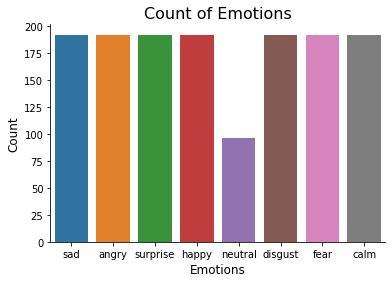

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(Ravdess_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# Exploración de datos


In [ ]:
df= Ravdess_df

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

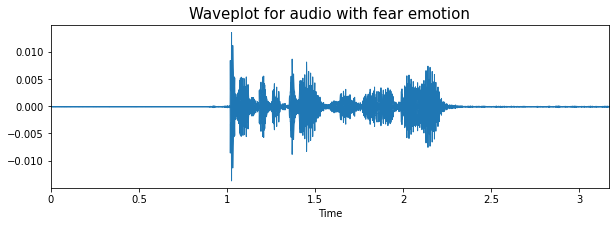

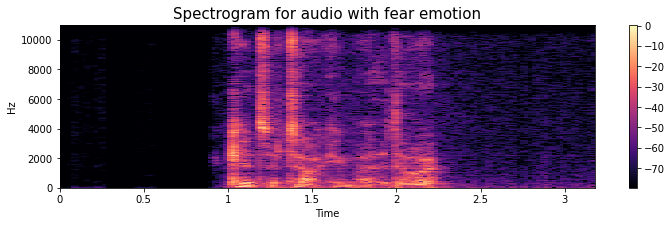

In [ ]:
emotion='fear'
path = np.array(df.Path[df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

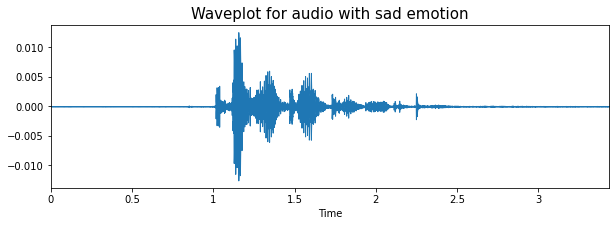

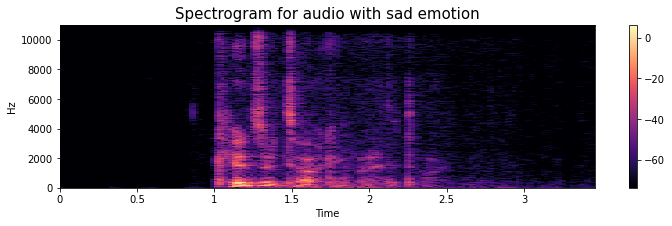

In [ ]:
emotion='sad'
path = np.array(df.Path[df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

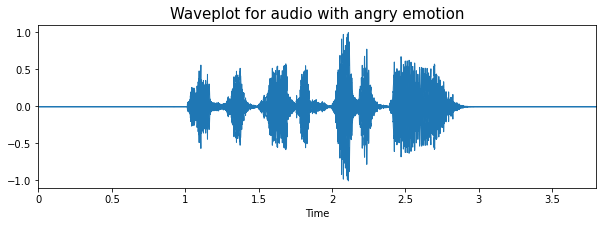

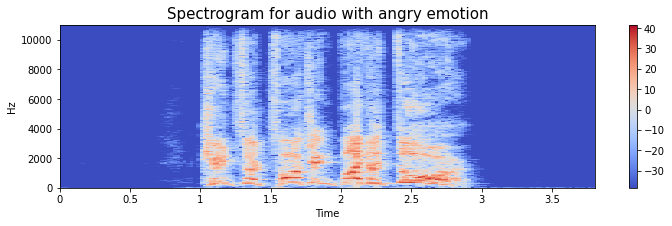

In [ ]:
emotion='angry'
path = np.array(df.Path[df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

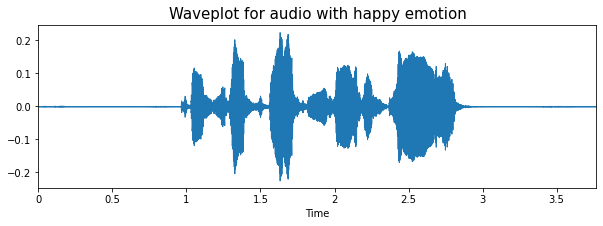

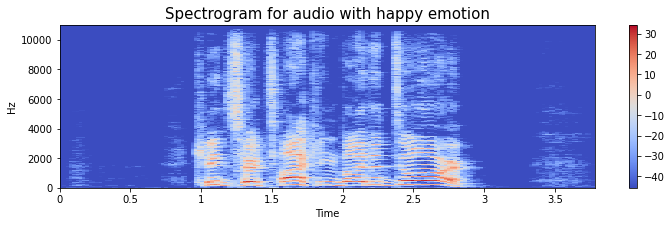

In [ ]:
emotion='happy'
path = np.array(df.Path[df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(df.Path)[1]
data, sample_rate = librosa.load(path)

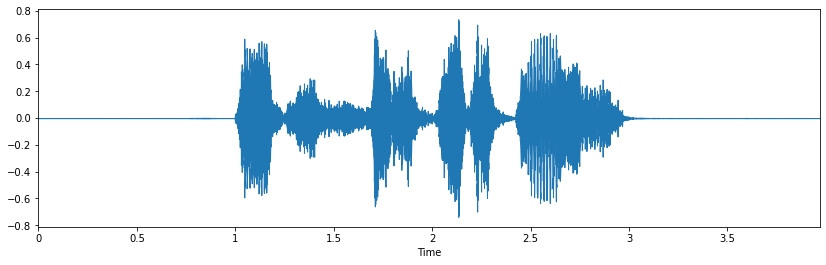

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

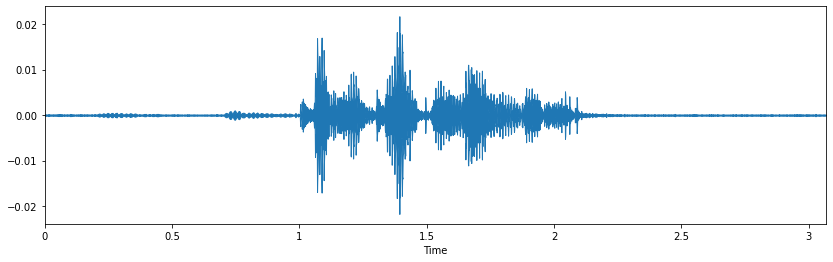

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

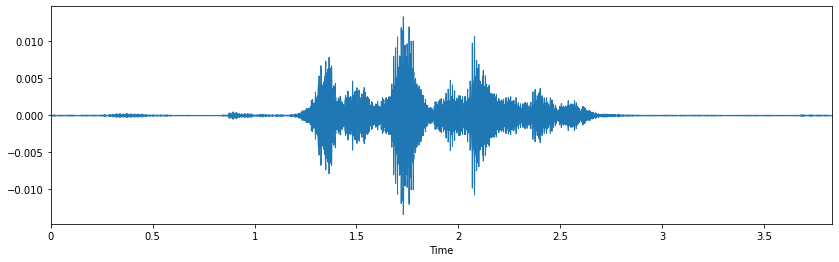

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

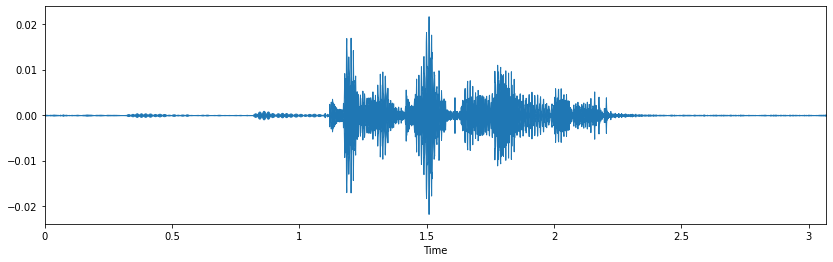

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

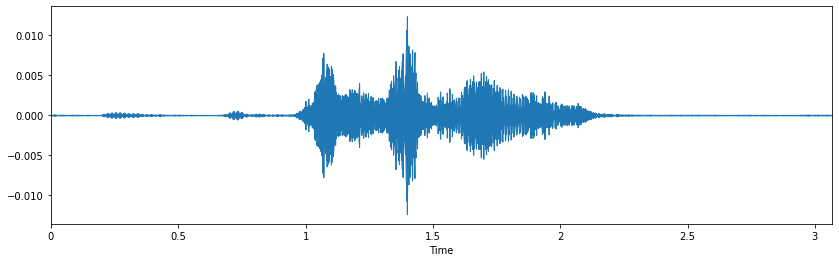

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(df.Path, df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
len(X), len(Y), df.Path.shape

(4320, 4320, (1440,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features_ravdess.csv', index=False)
Features.head()

ValueError: ignored

In [ ]:
from google.colab import files
files.upload()

In [ ]:
Features= pd.read_csv('/content/features_ravdess.csv')
Features.head()

0         1         2  ...       160           161  labels
0  0.221960  0.619836  0.618032  ...  0.000010  6.230272e-07     sad
1  0.265046  0.661175  0.666301  ...  0.000012  1.993128e-06     sad
2  0.108807  0.706086  0.651471  ...  0.000002  1.227283e-07     sad
3  0.180153  0.390722  0.446311  ...  0.007053  6.913386e-04   angry
4  0.269735  0.533754  0.530170  ...  0.087832  7.795907e-02   angry

[5 rows x 163 columns]

## split data

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values


In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, train_size=0.8, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3456, 162), (3456, 8), (864, 162), (864, 8))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3456, 162, 1), (3456, 8), (864, 162, 1), (864, 8))

## model

In [ ]:

model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(x_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(8)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 162, 256)          2304      
_________________________________________________________________
activation_18 (Activation)   (None, 162, 256)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 162, 256)          524544    
_________________________________________________________________
batch_normalization_4 (Batch (None, 162, 256)          1024      
_________________________________________________________________
activation_19 (Activation)   (None, 162, 256)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 162, 256)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 20, 256)          

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
108/108 [==============================] - 4s 31ms/step - loss: 0.9631 - accuracy: 0.6369 - val_loss: 1.8528 - val_accuracy: 0.3657
Epoch 2/50
108/108 [==============================] - 3s 27ms/step - loss: 0.9282 - accuracy: 0.6554 - val_loss: 2.4808 - val_accuracy: 0.3345
Epoch 3/50
108/108 [==============================] - 3s 27ms/step - loss: 0.9099 - accuracy: 0.6617 - val_loss: 2.1338 - val_accuracy: 0.3461
Epoch 4/50
108/108 [==============================] - 3s 28ms/step - loss: 0.8778 - accuracy: 0.6701 - val_loss: 1.8112 - val_accuracy: 0.3958
Epoch 5/50
108/108 [==============================] - 3s 28ms/step - loss: 0.8827 - accuracy: 0.6652 - val_loss: 1.6718 - val_accuracy: 0.4120
Epoch 6/50
108/108 [==============================] - 3s 28ms/step - loss: 0.8800 - accuracy: 0.6690 - val_loss: 1.6773 - val_accuracy: 0.4144
Epoch 7/50
108/108 [==============================] - 3s 27ms/step - loss: 0.8148 - accuracy: 0.6904 - val_loss: 1.9405 - val_accuracy: 0.3900

27/27 [==============================] - 0s 12ms/step - loss: 1.9471 - accuracy: 0.4780
Accuracy of our model on test data :  47.80092537403107 %


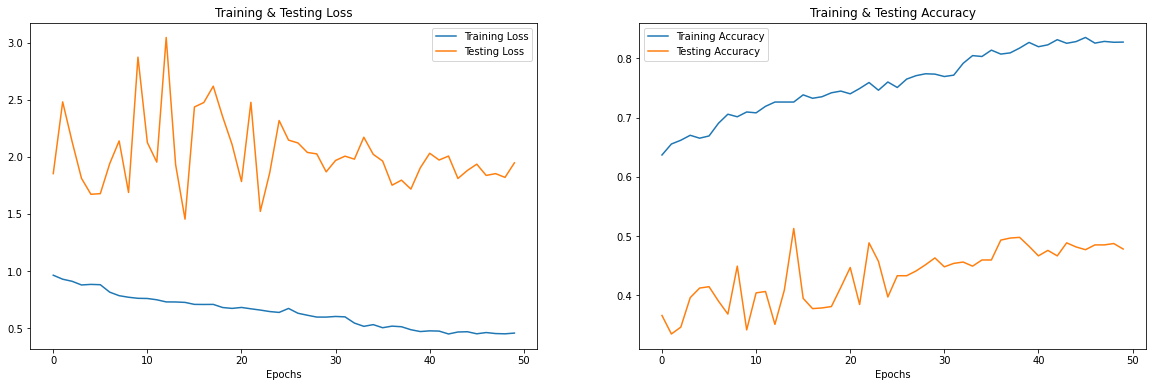

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0            happy         happy
1         surprise      surprise
2          disgust       disgust
3            happy          fear
4         surprise       disgust
5            angry         angry
6              sad       neutral
7          disgust          calm
8             calm          calm
9          disgust      surprise

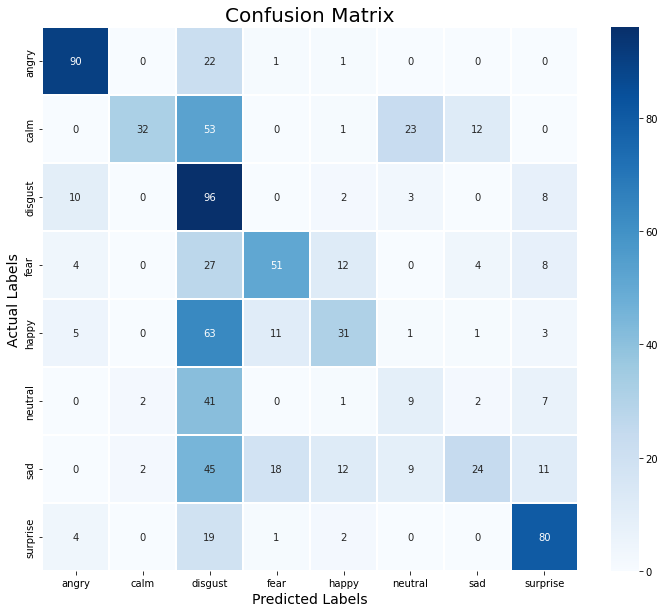

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.80      0.79      0.79       114
        calm       0.89      0.26      0.41       121
     disgust       0.26      0.81      0.40       119
        fear       0.62      0.48      0.54       106
       happy       0.50      0.27      0.35       115
     neutral       0.20      0.15      0.17        62
         sad       0.56      0.20      0.29       121
    surprise       0.68      0.75      0.72       106

    accuracy                           0.48       864
   macro avg       0.56      0.46      0.46       864
weighted avg       0.58      0.48      0.47       864

